In [154]:
import numpy as np 
from torch.utils.data import DataLoader 
import pandas as pd 
from sklearn import metrics 
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans 
from sklearn.manifold import TSNE 
from sklearn.cluster import DBSCAN 
import matplotlib.pyplot as plt 
import seaborn as sns 
from torchvision import datasets, transforms

In [155]:
# Load Fashin MNIST data and Evaluation Metrics
Fashion_mnist_test_transform = transforms.Compose([transforms.ToTensor()]) 
 
testset_Fashion_mnist = datasets.FashionMNIST(root='./data', train=False, download=True, 
transform=Fashion_mnist_test_transform) 
 
FM_test = DataLoader(testset_Fashion_mnist, batch_size=32, shuffle=False, num_workers=2)    
 
FM_test_images = [] 
FM_test_labels = [] 
 
for batch in FM_test: 
      images, labels = batch 
      images_flat = images.view(images.shape[0], -1) 
      FM_test_images.append(images_flat.numpy()) 
      FM_test_labels.append(labels.numpy()) 
FM_test_images = np.vstack(FM_test_images) 
FM_test_labels = np.concatenate(FM_test_labels) 

In [156]:
# Convert data to pandas DataFrame and Series
X_ = pd.DataFrame(data=FM_test_images) # 학습을 위한 test 데터터
y_ = pd.Series(data=FM_test_labels)    # label은 시각화를 위해 사용

In [224]:
# dimension reduction 을 위한 PCA 적용 함수
def apply_pca(X, n_components):
    pca = PCA(n_components=n_components)
    X_PCA = pca.fit_transform(X)
    return X_PCA

In [225]:
# ARI를 이용하여 clustering 결과 계산
def evaluate_clustering(true_labels, cluster_labels):
    return metrics.adjusted_rand_score(true_labels, cluster_labels)


In [226]:
def transform_pca_to_tsne(X):
    # tSNE config
    n_components = 2
    learning_rate = 300
    perplexity = 30
    early_exaggeration = 12
    init = 'random'
    # TSNE 객체 생성
    tSNE = TSNE(n_components=n_components, learning_rate=learning_rate, perplexity=perplexity, early_exaggeration=early_exaggeration, init=init)

    # PCA to pandas Dataframe 
    test_PCA = pd.DataFrame(data=X)
    # X_DataFrame to tSNE
    X_test_tSNE = tSNE.fit_transform(test_PCA.loc[:,:])
    # tSNE to DataFrame
    X_test_tSNE = pd.DataFrame(data=X_test_tSNE)

    return X_test_tSNE

In [227]:
# Kmeans clustering algorithm 구현
def kmeans_clustering(X, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters).fit(X)
    labels = kmeans.labels_
    return labels

In [228]:
# DBSCAN clustering algorithm 구현
def dbscan_clustering(X, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1).fit(X) # n_jobs=-1 : 모든 프로세서 사용
    return dbscan.labels_

In [197]:
dimensions = [784, 100, 50, 10]
X_transformed = []
for dim in dimensions:
    if dim == 784:
      X_pca = X_
    else:
      X_pca = apply_pca(X_, n_components=dim) 
    
    X_transformed.append(transform_pca_to_tsne(X_pca)) # PCA 적용 후, tSNE로 변환
    
print("Ready to find best parameters")
X_transformed

Ready to find best parameters


[              0          1
 0     35.483471 -52.809658
 1    -68.789330  33.481133
 2     70.394501  38.187527
 3     61.798878  27.428017
 4    -44.913010   5.798463
 ...         ...        ...
 9995  57.689651 -42.325390
 9996  62.527325  19.829182
 9997 -15.261295 -12.667628
 9998  47.900890  22.911533
 9999   8.524613 -53.190235
 
 [10000 rows x 2 columns],
               0          1
 0     -6.159125 -63.892483
 1    -45.743370  58.295635
 2     87.480553   2.571933
 3     83.958992  12.618588
 4    -29.139069  18.908455
 ...         ...        ...
 9995  17.338839 -68.757904
 9996  70.883377  -3.843194
 9997  -9.838756  -7.437306
 9998  85.218063  27.141806
 9999 -25.423191 -50.608612
 
 [10000 rows x 2 columns],
               0          1
 0    -61.288956 -18.626848
 1     74.397209  23.731283
 2    -13.915417  78.328926
 3    -26.360434  69.155846
 4     30.997841  25.479342
 ...         ...        ...
 9995 -55.824486 -42.729607
 9996 -29.122242  61.090523
 9997  11.528014  

In [229]:
# hyper parameter search for DBSCAN
def find_best_params_dbscan(true_labels):    
    # eps 탐색 구간 및 step 크기 설정
    start_eps = 0.5
    stop_eps = 10.0
    step_eps = 0.1
    eps_list = np.arange(start_eps, stop_eps, step_eps)

    # min sample 탐색 구간 및 step 크기 설정
    start_sample = 5
    stop_sample = 105
    step_sample = 1
    min_sample_list = np.arange(start_sample, stop_sample, step_sample)

    # 각 차원마다 가장 최상위 3개 ari score와 parameter set([best_eps, best_min_sample]) 캐싱
    best_params_per_dim = {dim: [] for dim in [784, 100, 50, 10]}

    # tSNE가 적용된 데이터 셋에 대해서 최고의 파라미터 찾기\
    for dim, X_test_tSNE in zip(dimensions, X_transformed):
        for eps in eps_list:
            for min_sample in min_sample_list:
                labels = dbscan_clustering(X_test_tSNE, eps, min_sample)
                cur_score = evaluate_clustering(true_labels, labels)
                print(f"ARI score for dim={dim}, eps={eps}, min_samples={min_sample} is {cur_score}")

                n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
                
                if n_clusters_ >= 9 and n_clusters_ <= 12: # 9개 이상, 12 개 이하의 cluster만 계산
                    best_params_per_dim[dim].append((cur_score, eps, min_sample))
                    best_params_per_dim[dim].sort(reverse=True, key=lambda x: x[0])
                    best_params_per_dim[dim] = best_params_per_dim[dim][:3]
                    print(f"Updated best parameters for dim={dim}: {best_params_per_dim[dim]}")

    return best_params_per_dim

In [ ]:
# dbscan 최적 파라미터 찾기
best_params_per_dim = find_best_params_dbscan(y_)

for dim, params in best_params_per_dim.items():
    print(f"Top 3 parameters for dim={dim}: {params}")

ARI score for dim=784, eps=0.5, min_samples=5 is 0.0003693086367906478
ARI score for dim=784, eps=0.5, min_samples=6 is 7.276048024449095e-05
ARI score for dim=784, eps=0.5, min_samples=7 is 1.9302887571119316e-05
Updated best parameters for dim=784: [(1.9302887571119316e-05, 0.5, 7)]
ARI score for dim=784, eps=0.5, min_samples=8 is 6.469779958541042e-06
ARI score for dim=784, eps=0.5, min_samples=9 is 2.8849007534847076e-06
ARI score for dim=784, eps=0.5, min_samples=10 is 0.0
ARI score for dim=784, eps=0.5, min_samples=11 is 0.0
ARI score for dim=784, eps=0.5, min_samples=12 is 0.0
ARI score for dim=784, eps=0.5, min_samples=13 is 0.0
ARI score for dim=784, eps=0.5, min_samples=14 is 0.0
ARI score for dim=784, eps=0.5, min_samples=15 is 0.0
ARI score for dim=784, eps=0.5, min_samples=16 is 0.0
ARI score for dim=784, eps=0.5, min_samples=17 is 0.0
ARI score for dim=784, eps=0.5, min_samples=18 is 0.0
ARI score for dim=784, eps=0.5, min_samples=19 is 0.0
ARI score for dim=784, eps=0.5,

In [211]:
best_params = {}  # Initialize best parameters dictionary

for dim, params_list in best_params_per_dim.items():
    max_ari_for_dim = max(params[0] for params in params_list)  # Find the maximum ARI for the current dimension
    for params in params_list:
        if params[0] == max_ari_for_dim:
            best_params[dim] = {'ari': params[0], 'eps': params[1], 'min_samples': params[2]}  # Store parameters with the best ARI
            break

print("Best parameters (max ARI score) per dimension:")
best_params

Best parameters (max ARI score) per dimension:


{784: {'ari': 0.40989973026557824,
  'eps': 6.199999999999998,
  'min_samples': 93},
 100: {'ari': 0.45724613663426666,
  'eps': 2.1999999999999997,
  'min_samples': 9},
 50: {'ari': 0.45797355801094264,
  'eps': 2.6999999999999993,
  'min_samples': 13},
 10: {'ari': 0.4353457066097648, 'eps': 5.299999999999999, 'min_samples': 55}}

In [211]:
best_params = {}  # Initialize best parameters dictionary

for dim, params_list in best_params_per_dim.items():
    max_ari_for_dim = max(params[0] for params in params_list)  # Find the maximum ARI for the current dimension
    for params in params_list:
        if params[0] == max_ari_for_dim:
            best_params[dim] = {'ari': params[0], 'eps': params[1], 'min_samples': params[2]}  # Store parameters with the best ARI
            break

print("Best parameters (max ARI score) per dimension:")
best_params

Best parameters (max ARI score) per dimension:


{784: {'ari': 0.40989973026557824,
  'eps': 6.199999999999998,
  'min_samples': 93},
 100: {'ari': 0.45724613663426666,
  'eps': 2.1999999999999997,
  'min_samples': 9},
 50: {'ari': 0.45797355801094264,
  'eps': 2.6999999999999993,
  'min_samples': 13},
 10: {'ari': 0.4353457066097648, 'eps': 5.299999999999999, 'min_samples': 55}}

In [220]:
# DBSCAN 테스트 시점에는 모두 동일한 파라미터로 학습
dbscan_eps = 2.3
dbscan_min_samples = 10

In [221]:
# clustering 결과 시각화.
def visualize_with_tsne(X_reduced, y, algo_type, ari_table, plt_title, sample_size=100):
    # PCA -> tSNE 변환
    X_test_tSNE = transform_pca_to_tsne(X_reduced)

    test_PCA = pd.DataFrame(data=X_reduced)
    testDF = pd.DataFrame(data=X_test_tSNE.loc[:,:], index=test_PCA.index)
    testDF = pd.concat((testDF,y_), axis=1, join="inner")
    testDF.columns = ["x-axis", "y-axis", "Label"]

    ############### Clustering Algorithm ###############
    if algo_type == "kmeans":
        labels = kmeans_clustering(X_test_tSNE)
    else:
        labels = dbscan_clustering(X_test_tSNE, dbscan_eps, dbscan_min_samples)

    ari_table.append(evaluate_clustering(y, labels)) # ari score compute
    ####################################################

    # label column에 clustering 결과 할당
    labels = pd.DataFrame(data=labels)
    testDF["Label"] = labels # label to DataFrame
    
    # 결과 샘플링
    sns.lmplot(x="x-axis", y="y-axis", hue="Label", data=testDF, fit_reg=False, height=8)
    plt.title(plt_title)

    plt.grid()
    
    testDF_sampled = testDF.sample(n=sample_size)
    sns.lmplot(x="x-axis", y="y-axis", hue="Label", data=testDF_sampled, fit_reg=False, height=8)
    plt.title(plt_title+" (100 Samples)")
    
    plt.grid()

   Dimensions  K-means ARI  DBSCAN ARI
0         784     0.401803    0.370735
1         100     0.419030    0.410572
2          50     0.393332    0.405772
3          10     0.410534    0.405525


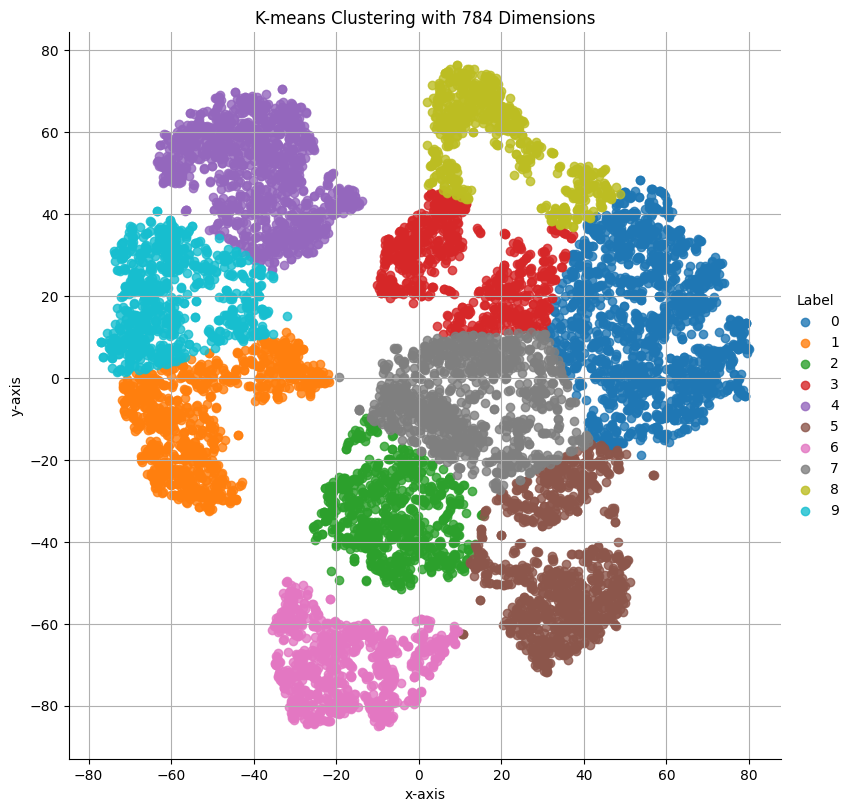

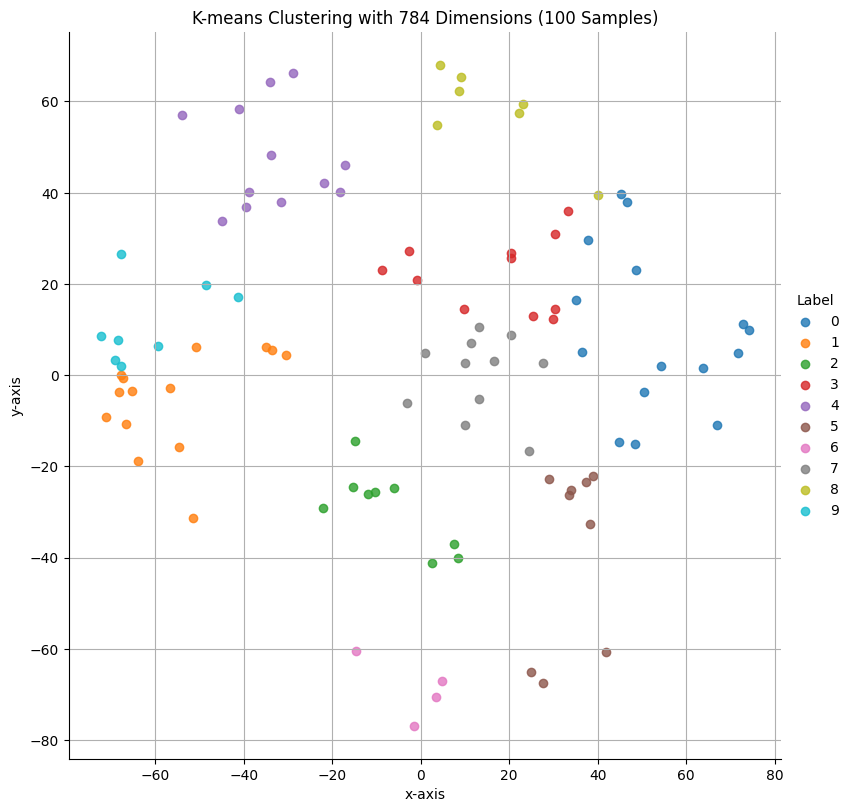

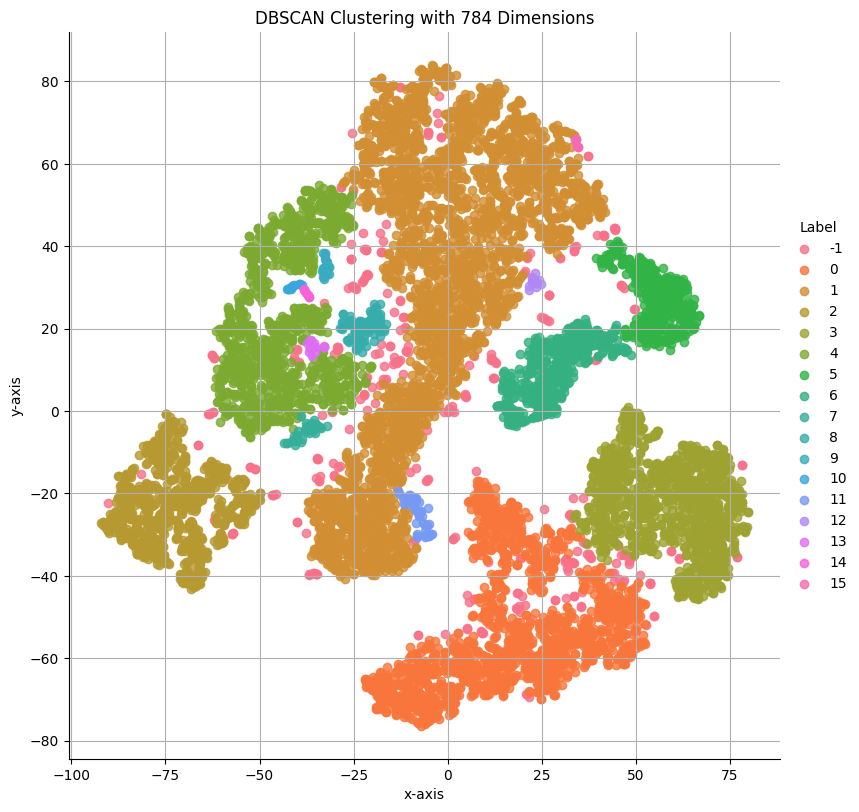

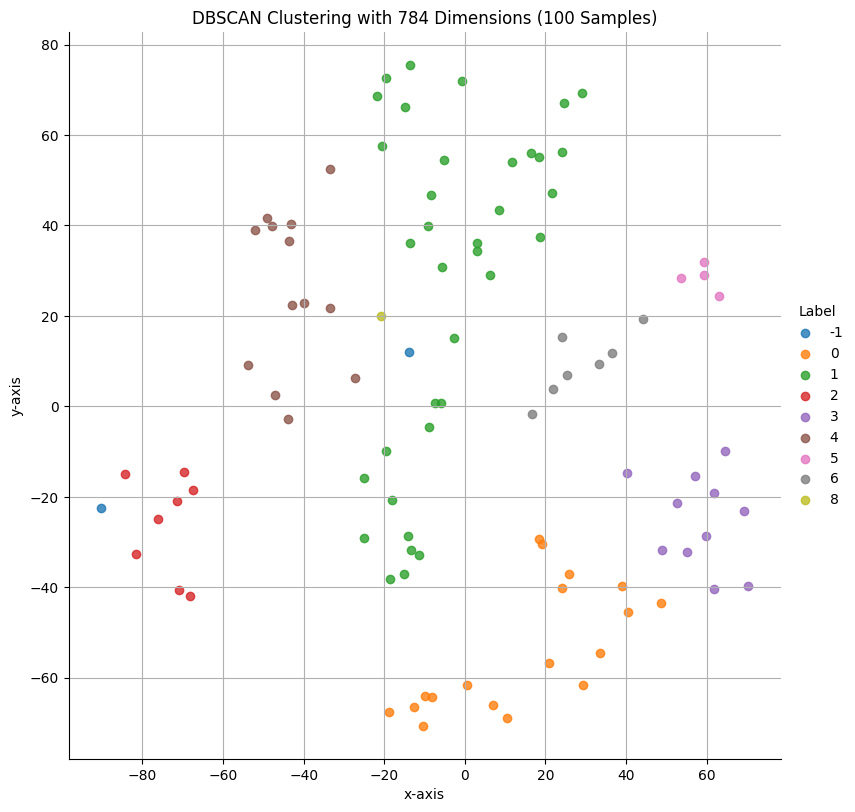

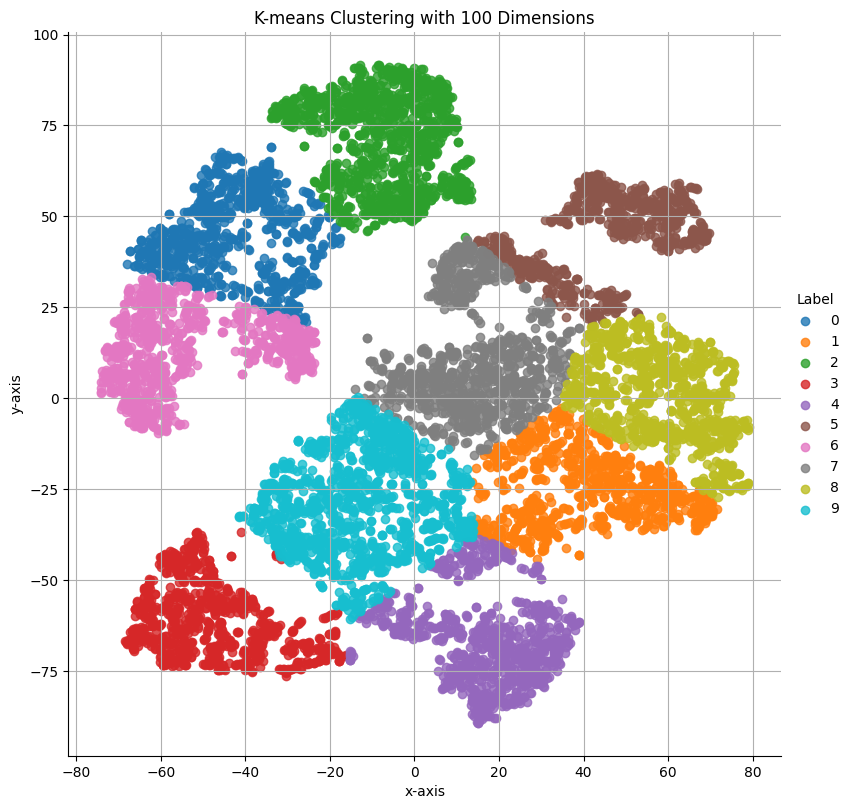

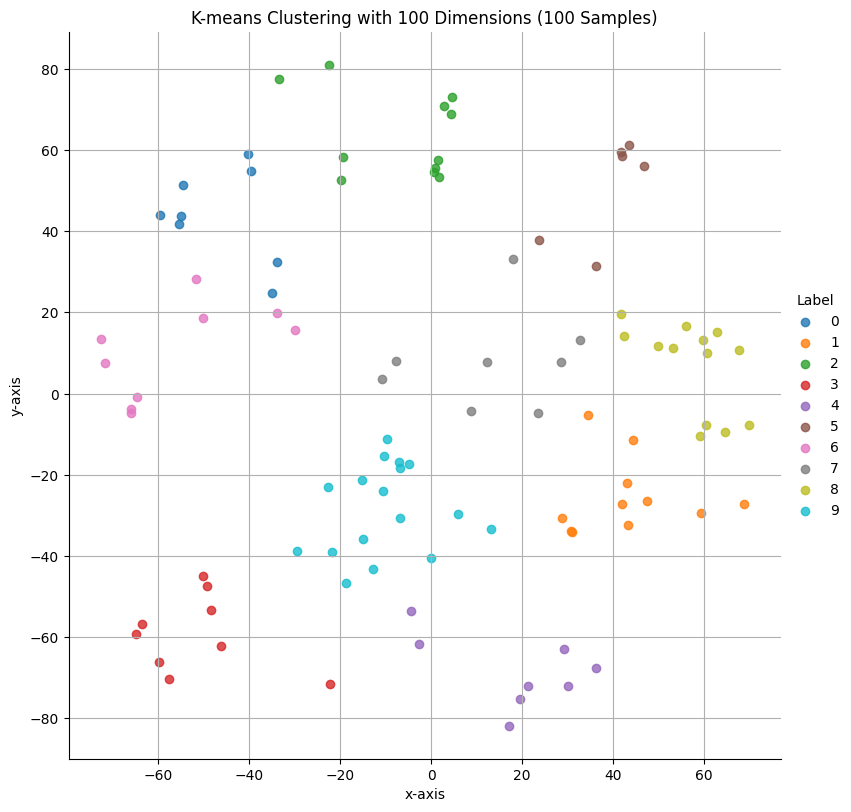

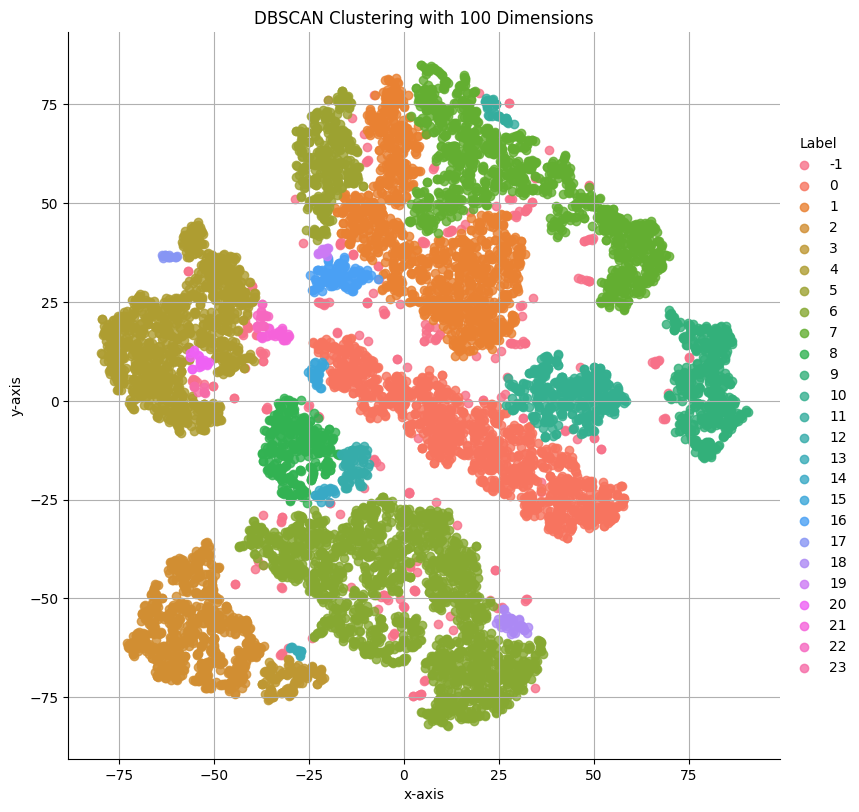

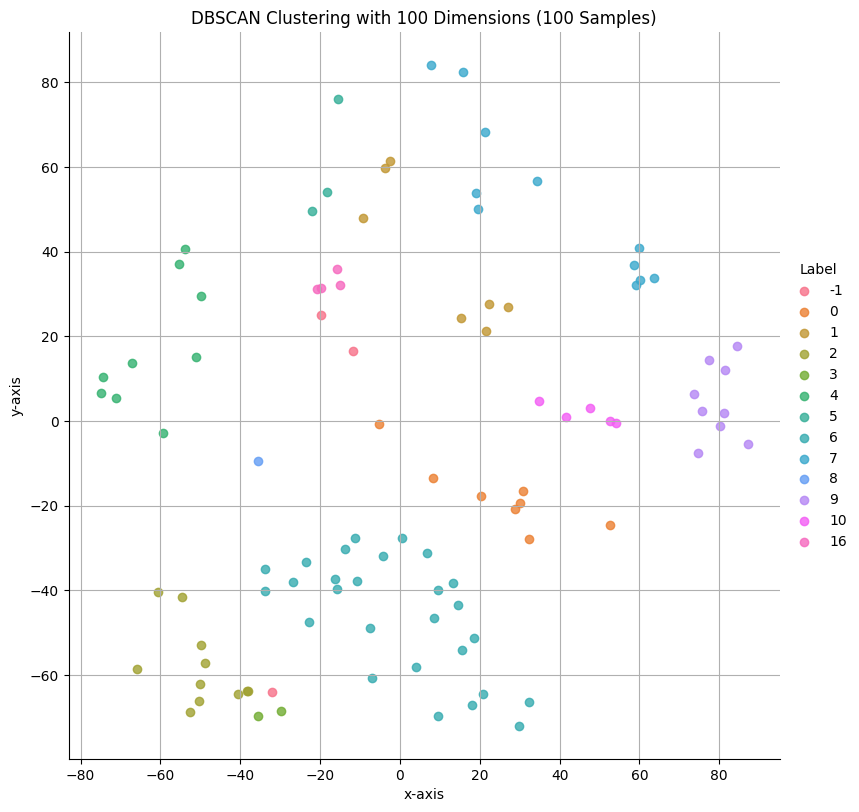

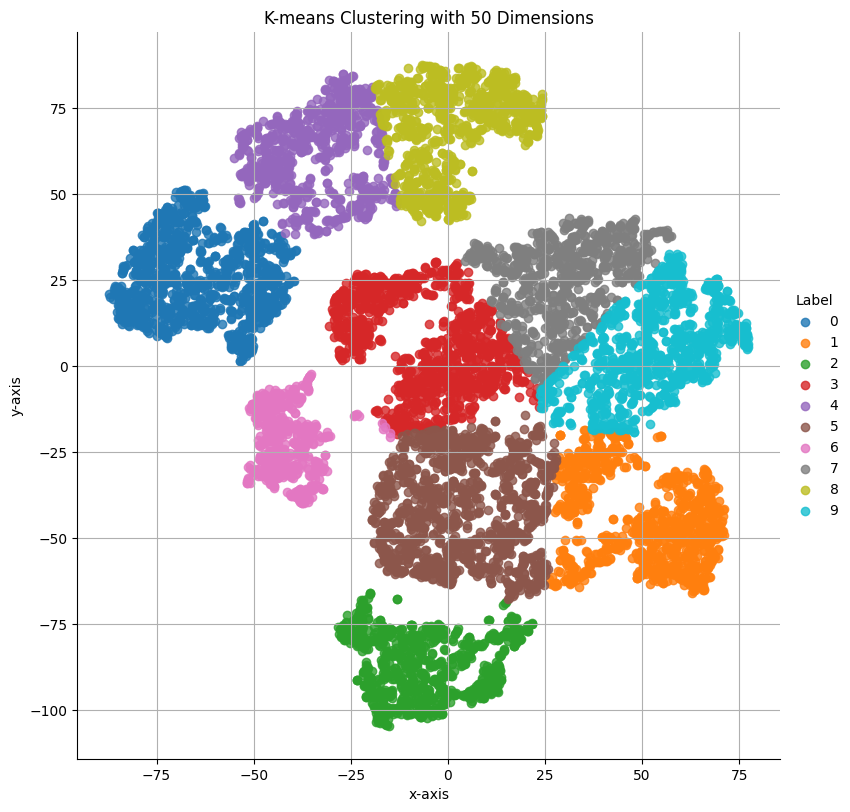

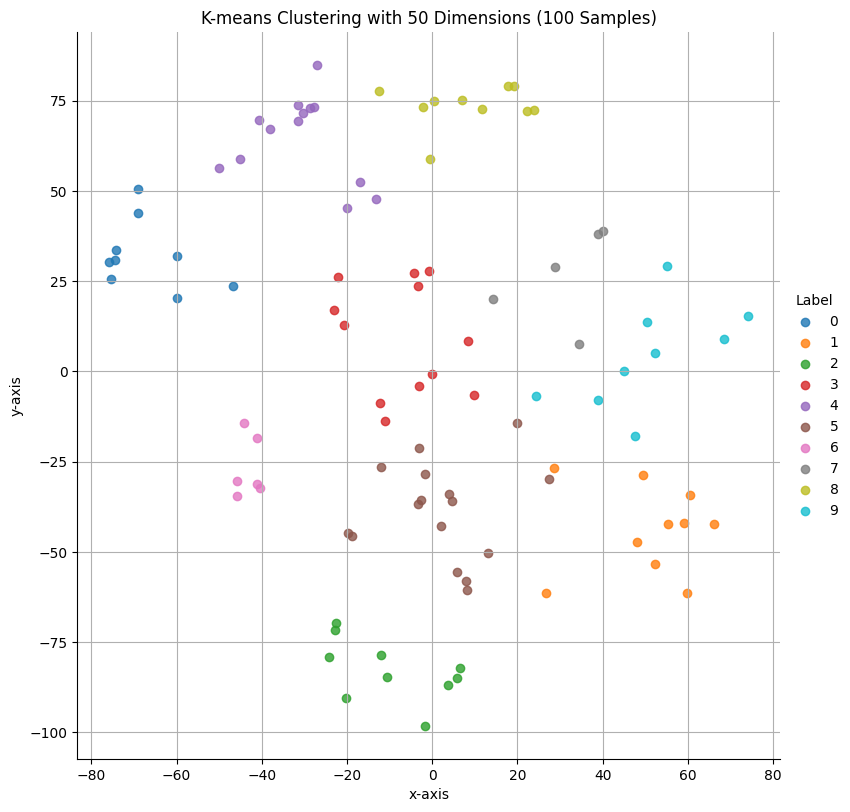

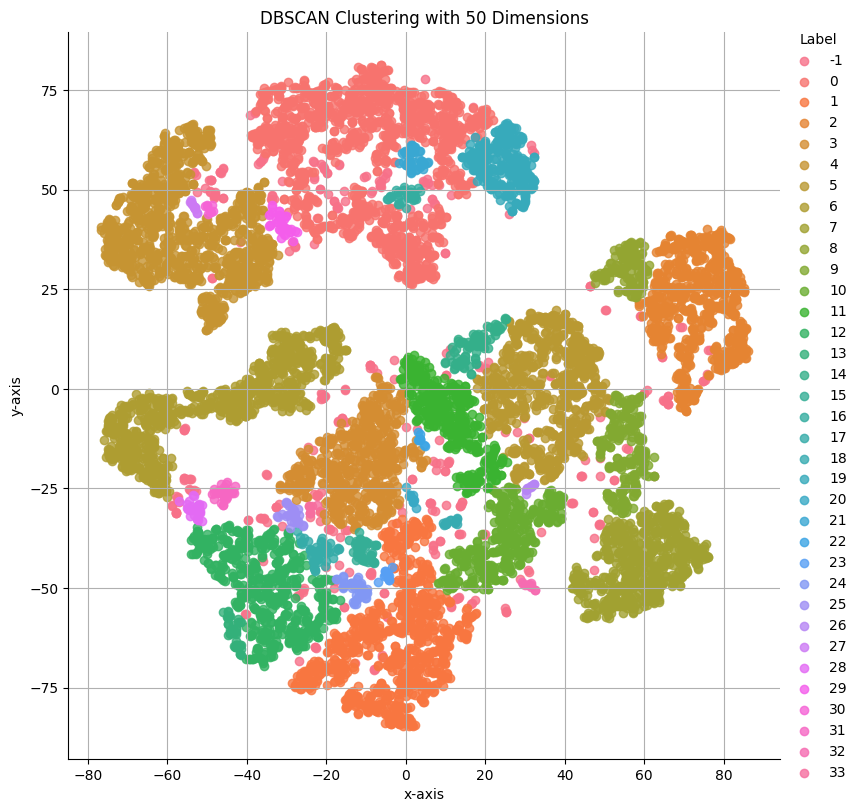

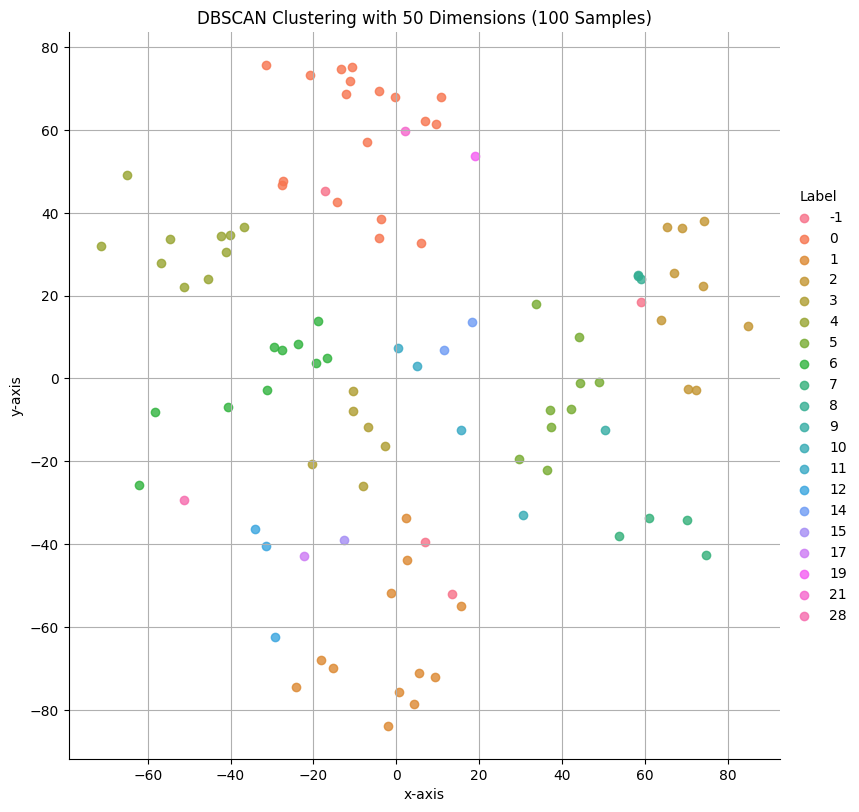

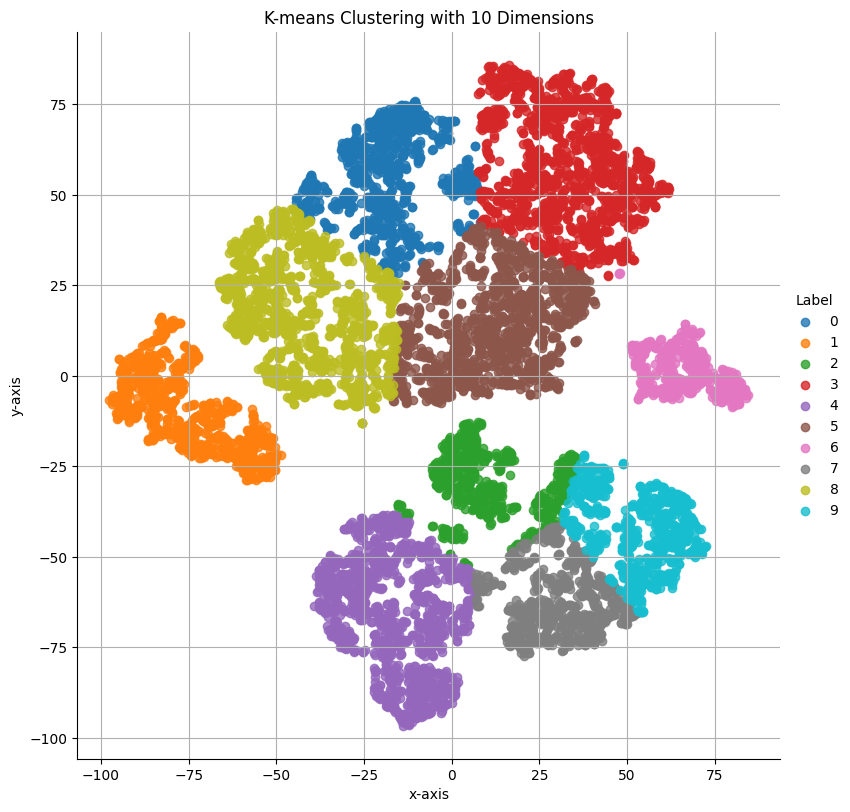

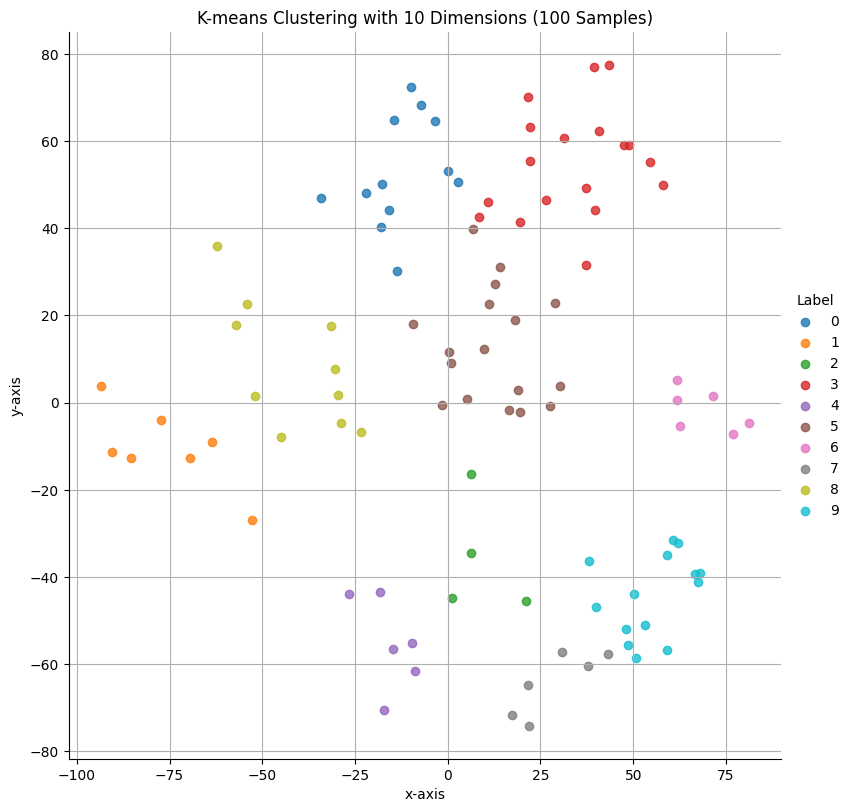

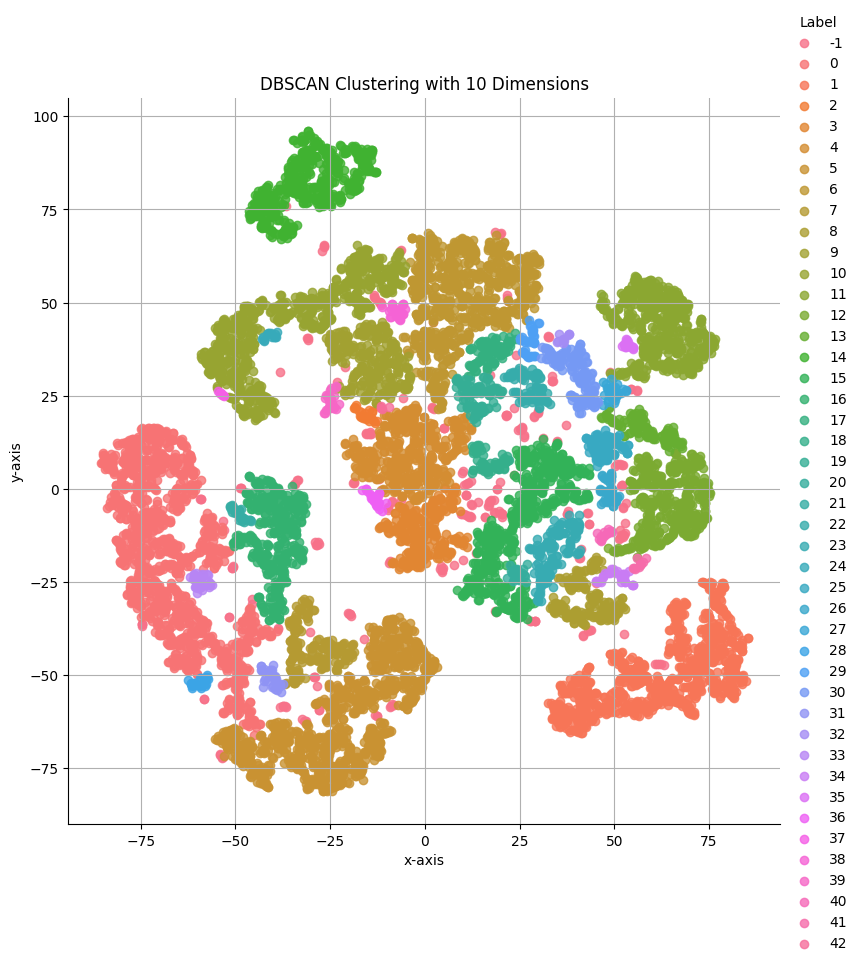

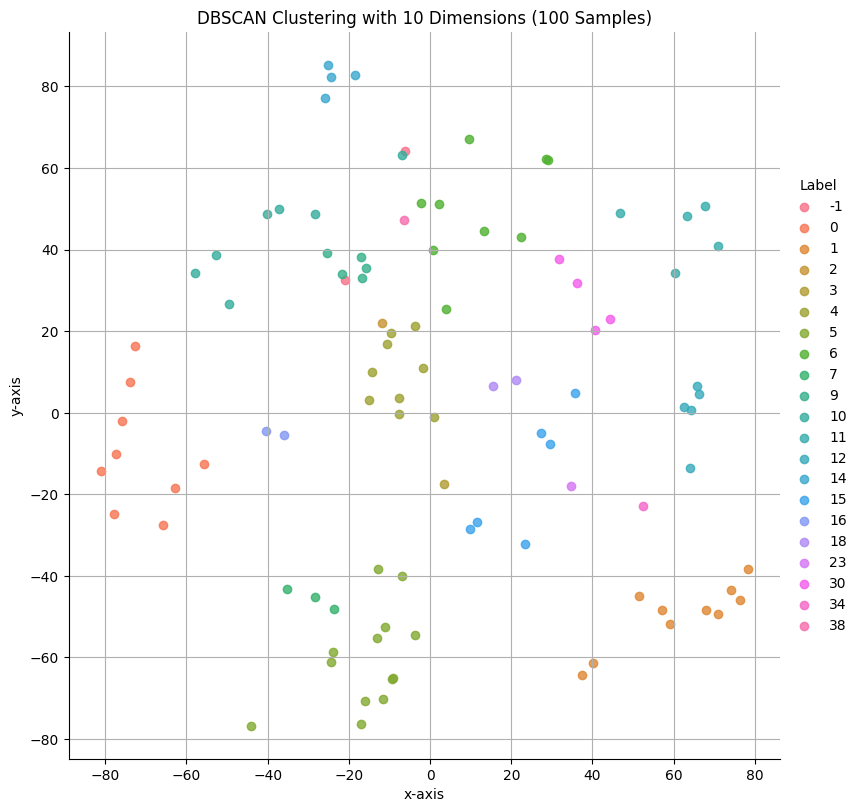

In [222]:
# main execution

dimensions = [784, 100, 50, 10] 
ari_kmeans = []
ari_dbscan = []

for dim in dimensions:
    # pca 적용
    if dim == 784:
        X_reduced = X_ # 원본 이미지 차원
    else:
        X_reduced = apply_pca(X_, n_components=dim)
    
    # KMeans
    kmeans_title = "K-means Clustering with {} Dimensions".format(str(dim)) 
    visualize_with_tsne(X_reduced, y_, "kmeans", ari_kmeans, kmeans_title)
    
    # DBSCAN
    dbscan_title = "DBSCAN Clustering with {} Dimensions".format(str(dim))
    visualize_with_tsne(X_reduced, y_, "dbscan", ari_dbscan, dbscan_title)

# Show ARI results
ari_results = pd.DataFrame({
    'Dimensions': dimensions,
    'K-means ARI': ari_kmeans,
    'DBSCAN ARI': ari_dbscan
})
print(ari_results)
